## Interpretable Model 
- ICANN model
- with skeleton decoder
- and two new reconstruction losses
- 3 BiLSTM layers
- fixed single skeleton seq.
- freeze & non-freeze model 
  

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install neptune
! git clone https://github.com/nipdep/HAR-ZSL-XAI.git --branch pd/PoseAE --single-branch
! mv /content/HAR-ZSL-XAI/src /content/

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 448.1/448.1 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 73.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.6 MB/s eta 0:00:00
Cloning into 'HAR-ZSL-XAI'...
remote: Enumerating objects: 255, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (54/54), done.
remote: To

---

In [3]:
data_root = '/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Datasets/Consolidated/PAMPA2'

In [4]:
from datetime import date, datetime
from tqdm.autonotebook import tqdm
from copy import deepcopy
from collections import defaultdict
import numpy as np 
import numpy.random as random
import pandas as pd
import json
import pickle
from collections import defaultdict, OrderedDict
# import neptune

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader, PAMAP2ReaderV2
# from src.datasets.dataset import PAMAP2Dataset
from src.utils.analysis import action_evaluator
from src.datasets.utils import load_attribute

from src.models.loss import FeatureLoss, AttributeLoss
from src.utils.losses import *
from src.utils.analysis import action_evaluator

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity


<ipython-input-4-6bb350ee5c45>:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from sklearn.manifold import TSNE
# from umap import UMAP

import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px

---

In [32]:
# setup model configurations
config = {
    # general information
    "experiment-name": "Experiment_section-1", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "BiLSTM",
    "sem-space": 'I3D embeddings',
    # model training configs
    "lr": 0.0001,
    "imu_alpha": 0.0001,
    "n_epochs": 20,
    "freeze_n": 15,
    "batch_size": 64,
    # model configs
    "d_model": 128, 
    "num_heads": 3,
    "feat_size": 400, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5.21, 
    "overlap": 4.21,
    "seq_len": 20,  # skeleton seq. length
    "seen_split": 0.1,
    "unseen_split": 0.8,

}

---

In [7]:
IMU_data_path = data_root+'/IMU/Protocol/'
dataReader = PAMAP2ReaderV2(IMU_data_path)
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


/content/src/datasets/data.py:1275: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [8]:
def read_I3D_pkl(loc,feat_size="400"):
  if feat_size == "400":
    feat_index = 1
  elif feat_size == "2048":
    feat_index = 0
  else:
    raise NotImplementedError()

  with open(loc,"rb") as f0:
    __data = pickle.load(f0)

  label = []
  prototype = []
  for k,v in __data.items():
    label.append(k)
    all_arr = [x[feat_index] for x in v]
    all_arr = np.array(all_arr).mean(axis=0)
    prototype.append(all_arr)

  label = np.array(label)
  prototype = np.array(prototype)
  return {"activity":label, "features":prototype}

In [9]:
# load video dataset
skeleton_data = np.load(data_root+'/Skeletons/skeleton_mediapipe.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']
new_fts = [i for i in range(skeleton_mov.shape[-1]) if i%3 != 2]
seq_len = 60
skeleton_mov = skeleton_mov[:, :seq_len, new_fts]

skel_mean = defaultdict(list)
for i,c in enumerate(skeleton_classes):
    skel_mean[c] = skeleton_mov[i]

# skel_mean = {}
# for k,v in skel_dict.items():
#     # print( np.array(v).shape)
#     skel_mean[k] = np.array(v).mean(axis=0)

In [10]:
# load video dataset
I3D_data_path  = data_root + '/I3D/video_feat.pkl'
video_data = read_I3D_pkl(I3D_data_path,feat_size="400")
video_classes, video_feat = video_data['activity'], video_data['features']

In [11]:
video_feat.shape

(18, 400)

In [12]:
video_classes.shape

(18,)

In [13]:
label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
for i, a in enumerate(video_classes):
    action_dict[label2Id[a]].append(i)

In [14]:
skel_mean['Nordic walking'].shape

(60, 24)

In [15]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, skel_dict, action_classes, all_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.skel_dict = skel_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.Id2action = dict(zip(action_classes, [all_classes[i] for i in action_classes]))
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        target = self.actions[ind]
        target_name = self.Id2action[target]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences
        vid_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[vid_idx, ...]
        y_skel = self.skel_dict[target_name]
        return x, y, y_feat, y_skel

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat

    def getClassFeatures(self):
        cls_feat = []
        for c in self.action_classes:
            idx = self.attribute_dict[c]
            cls_feat.append(torch.mean(self.attributes[idx, ...], dim=0))

        cls_feat = torch.vstack(cls_feat)
        # print(cls_feat.size())
        return cls_feat

In [16]:
class IMUEncoder(nn.Module):
    def __init__(self, in_ft, d_model, ft_size, num_heads=1, dropout=0.1):
        super(IMUEncoder, self).__init__()
        self.in_ft = in_ft
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        self.lstm = nn.LSTM(input_size=self.in_ft,
                            hidden_size=self.d_model,
                            num_layers=self.num_heads,
                            batch_first=True,
                            bidirectional=True,
                            dropout=dropout)
        self.drop = nn.Dropout(p=0.1)
        self.act = nn.ReLU()
        self.fcLayer1 = nn.Linear(2*self.d_model, self.ft_size)
        # self.fcLayer2 = nn.Linear(self.ft_size, self.ft_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out_forward = out[:,-1, :self.d_model]
        out_reverse = out[:, 0, self.d_model:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        out = self.drop(out_reduced)
        out = self.act(out)
        out = self.fcLayer1(out)
        # out = self.fcLayer2(out)
        return out

In [17]:
sample_imu = IMUEncoder(in_ft=54, d_model=128, num_heads=3, ft_size=400)

imu_input = torch.randn((32, 60, 54))
imu_output = sample_imu(imu_input)
imu_output.shape

torch.Size([32, 400])

In [18]:
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.device = device
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.seq_len = seq_len

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        """
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence
        """
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((-1,4,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
            bs = h.size()[1]
        else:
            hidden = encoder_hidden.view((-1,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
            bs = h.size()[1]
        
        dummy_input = torch.rand((bs,self.seq_len,self.hidden_size), requires_grad=True).to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

In [19]:
sample_dec = BiLSTMDecoder(seq_len=60, input_size=24, hidden_size=128, linear_filters=[64, 128], embedding_size=400, num_layers=1, bidirectional=True)

skel_input = torch.randn((32, 400))
skel_output = sample_dec(skel_input)
skel_output.shape

torch.Size([32, 60, 24])

In [20]:
class CompoundModel(nn.Module):
    def __init__(self, config, freeze=False):
        super(CompoundModel, self).__init__()
        self.imu_encoder = IMUEncoder(**config['imu_config'])
        self.skel_decoder = BiLSTMDecoder(**config['skel_config'])
        self.device = config['device']

        if freeze:
            self.__freeze_model()

    def __freeze_model(self):
        for params in self.skel_decoder.parameters():
                params.requies_grad = False
    
    def unfreeze(self):
        for params in self.skel_decoder.parameters():
                params.requies_grad = True

    def forward(self, x):
        imu_feat = self.imu_encoder(x)
        skel_recon = self.skel_decoder(imu_feat)
        return imu_feat, skel_recon

In [21]:
imu_config = {
    'in_ft': 54,
    'd_model': 256,
    'ft_size': 400,
    'num_heads': 2,
    'dropout': 0.1
}

decoder_config = {
    'input_size': 24,
    'seq_len': 60,
    'hidden_size': 128,
    'linear_filters': [64, 128],
    'embedding_size': 400,
    'num_layers': 1,
    'bidirectional': True,
    # 'batch_size': 32,
    'device': 'cpu'
}

model_config = {
    'imu_config': imu_config,
    'skel_config': decoder_config,
    'device': 'cpu'
}

sample_model = CompoundModel(model_config)
sample_input = torch.randn((32, 78, 54))
output_y, output_recon = sample_model(sample_input)
print(output_y.shape, output_recon.shape)

torch.Size([32, 400]) torch.Size([32, 60, 24])


---

In [22]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [23]:
# run 5-fold running
fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [24]:
def loss_cross_entropy(y_pred, y, feat, loss_fn):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    output = loss_fn(softmax_vec, y)
    pred = torch.argmax(softmax_vec, dim=-1)
    return output, pred

def loss_reconstruction_calc(y_pred, y_feat, loss_fn=nn.L1Loss(reduction="sum")):
    loss = loss_fn(y_pred,y_feat)
    return loss

def predict_class(y_pred, feat):
    mm_vec = torch.mm(y_pred, torch.transpose(feat, 0, 1))
    feat_norm = torch.norm(feat, p=2, dim=1)
    norm_vec = mm_vec/torch.unsqueeze(feat_norm, 0)
    softmax_vec = torch.softmax(norm_vec, dim=1)
    pred = torch.argmax(softmax_vec, dim=-1)
    return pred

In [25]:
def train_step(model, dataloader, dataset, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7, loss_beta=0.5):
    model = model.train()
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    random_selected_feat = dataset.getClassFeatures().to(device)
    # print(random_selected_feat.shape)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, skel = batch
            # print(X.shape, targets.shape, target_feat.shape, skel.shape)
            X = X.float().to(device)
            skel = skel.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output, recon_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn=loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
                recon_loss = loss_module['recon_loss'](recon_output, skel)

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss + loss_beta*recon_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine
            pred_class = class_output.cpu().detach().numpy()
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [26]:
def eval_step(model, dataloader,dataset, loss_module, device, class_names,  phase='seen', l2_reg=False, print_report=False, show_plot=False, loss_alpha=0.7, loss_beta=0.5):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}
    metrics = {"samples": 0, "loss": 0, "feat. loss": 0, "classi. loss": 0, 'recon. loss': 0}

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, skel = batch
            X = X.float().to(device)
            skel = skel.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)

            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                feat_output, recon_output = model(X)
                class_loss, class_output = loss_cross_entropy(feat_output,targets.squeeze(),random_selected_feat,loss_fn =loss_module['class'] )
                feat_loss = loss_reconstruction_calc(feat_output,target_feat,loss_fn=loss_module["feature"])
                recon_loss = loss_module['recon_loss'](recon_output, skel)

            #loss = cross_entropy_loss
            loss = feat_loss + loss_alpha*class_loss + loss_beta*recon_loss
            # class_output = predict_class(feat_output,random_selected_feat)

            pred_action = class_output

            with torch.no_grad():
                metrics['samples'] += len(targets)
                metrics['loss'] += loss.item()  # add total loss of batch
                metrics['feat. loss'] += feat_loss.item()
                metrics['classi. loss'] += class_loss.item()
                metrics['recon. loss'] += recon_loss.item()

            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action.cpu().numpy())
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})

    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    metrics_dict.update(metrics)
    return metrics_dict

In [27]:
def plot_curves(df):
    df['loss'] = df['loss']/df['samples']
    df['feat. loss'] = df['feat. loss']/df['samples']
    df['classi. loss'] = df['classi. loss']/df['samples']
    df['recon. loss'] = df['recon. loss']/df['samples']
    
    fig, axs = plt.subplots(nrows=5)
    sns.lineplot(data=df, x='epoch', y='loss', hue='phase', marker='o', ax=axs[2]).set(title="Loss")
    sns.lineplot(data=df, x='epoch', y='feat. loss', hue='phase', marker='o', ax=axs[0]).set(title="Feature Loss")
    sns.lineplot(data=df, x='epoch', y='classi. loss', hue='phase', marker='o', ax=axs[1]).set(title="Classification Loss")
    sns.lineplot(data=df, x='epoch', y='recon. loss', hue='phase', marker='o', ax=axs[3]).set(title="Reconstruction Loss")
    sns.lineplot(data=df, x='epoch', y='accuracy', hue='phase', marker='o', ax=axs[4]).set(title="Accuracy")

In [28]:
def log(fold, phase, metrics):
    for m, v in metrics.items():
        if fold == 'global':
            run[f'global/{m}'].log(v)
        else:
            run[f"Fold-{fold}/{phase}/{m}"].log(v) 

In [29]:
def get_config(file_loc,device):
    file = torch.load(file_loc,map_location=device)
    return file["model_state_dict"], file["model_config"], file["config"]

model_params, model_config, saved_config = get_config(
    f"/content/drive/MyDrive/22_FYP42 - Zero-shot Explainable HAR/Devin/SkeletonAE/model_saves/temp_NTURGB120_skeleton_SGN_classifier/10__epoch50_emb400_xy.pt",
    device
    )

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']
seen classes >  [0, 1, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 16, 17]
unseen classes >  [7, 15, 2, 10]
Initiate IMU datasets ...


Training Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.342



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.499



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.816



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.814



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.842



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.917



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.920



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.917



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.918



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.930



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.935



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.937



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.941



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.957



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.965



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.967



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.974



train:   0%|          | 0/294 [00:00<?, ?batch/s]

seen:   0%|          | 0/32 [00:00<?, ?batch/s]

Overall accuracy: 0.973



unseen:   0%|          | 0/87 [00:00<?, ?batch/s]

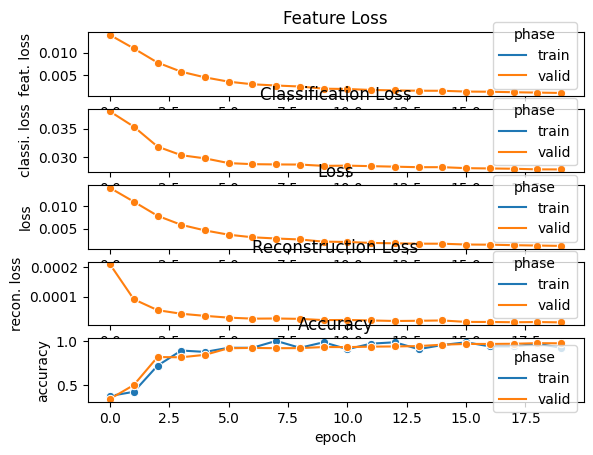

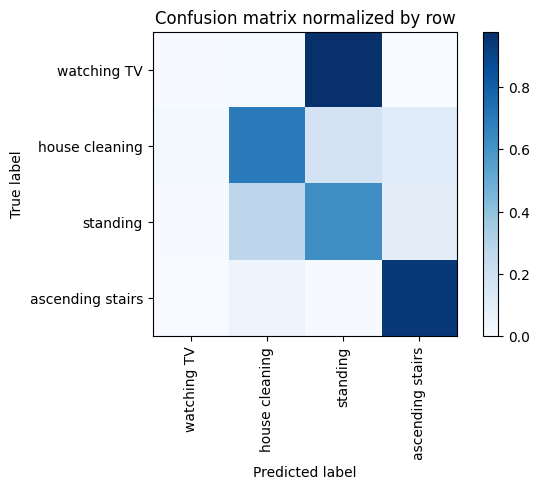

Overall accuracy: 0.616

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.503      0.623      0.556      0.331       1841|	 house cleaning: 0.270,	ascending stairs: 0.102,	
  house cleaning       0.694      0.693      0.693      0.329       1832|	 standing: 0.176,	ascending stairs: 0.116,	
ascending stairs       0.715      0.945      0.814      0.192       1071|	 house cleaning: 0.048,	standing: 0.007,	
     watching TV       0.095      0.005      0.009      0.148        824|	 standing: 0.977,	house cleaning: 0.015,	

----------------------------------------------------------------------------------------------------
     avg / total       0.546      0.616      0.570        1.0       5568|	      

{'accuracy': 0.6163793103448276, 'precision': 0.501720868655162, 'recall': 0.5663705544345418, 'f1': 0.5182603385683227, 'samples': 5568, 'loss': 97.20330262184143, 'feat. loss': 95.86180317401886, 'classi. loss': 94.56779980

In [34]:

# run['parameters'] = config
fold_metric_scores = []

for i, cs in enumerate(fold_cls_ids[:1]):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')

    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=config['window_size'], window_overlap=config['overlap'], resample_freq=config['seq_len'])
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    print("seen classes > ", seen_classes)
    print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=video_feat, attribute_dict=action_dict, skel_dict=skel_mean, action_classes=seen_classes, all_classes=all_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=video_feat, attribute_dict=action_dict, skel_dict=skel_mean, action_classes=seen_classes, all_classes=all_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=video_feat, attribute_dict=action_dict, skel_dict=skel_mean, action_classes=unseen_classes, all_classes=all_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    # build model
    imu_config = {
        'in_ft': in_ft,
        'd_model': config['d_model'],
        'ft_size': config['feat_size'],
        'num_heads': config['num_heads'],
        'dropout': 0.1
    }

    decoder_config = {
        'seq_len': saved_config["model"]["seq_len"],
        'input_size': saved_config["model"]["input_size"],
        'hidden_size': saved_config["model"]["decoder_hidden_size"],
        'linear_filters': saved_config["model"]["linear_filters"],
        'embedding_size': saved_config["model"]["embedding_size"],
        'num_layers': saved_config["model"]["num_layers"],
        'bidirectional': saved_config["model"]["bidirectional"],
        'device': device
    }

    model_config = {
        'imu_config': imu_config,
        'skel_config': decoder_config,
        'device': 'cpu'
    }
    model = CompoundModel(model_config, freeze=True)
    _ = model.load_state_dict(model_params, strict=False)
    model.to(device)

    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'], weight_decay=1e-6)
    loss_module = {'class': nn.CrossEntropyLoss(), 'feature': nn.L1Loss(), 'recon_loss': nn.MSELoss()}
    best_acc = 0.0

    # train the model 
    train_data = []
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        if epoch == config['freeze_n']:
            model.unfreeze()
    
        train_metrics = train_step(model, train_dl, train_dt,optimizer, loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=0.0001, loss_beta=0.9)
        train_metrics['epoch'] = epoch
        train_metrics['phase'] = 'train'
        train_data.append(train_metrics)
        # log(i, 'train', train_metrics)

        eval_metrics = eval_step(model, eval_dl, eval_dt,loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='seen', loss_alpha=0.0001, loss_beta=0.9, print_report=False, show_plot=False)
        eval_metrics['epoch'] = epoch 
        eval_metrics['phase'] = 'valid'
        train_data.append(eval_metrics)
        # log(i, 'eval', eval_metrics)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    train_df = pd.DataFrame().from_records(train_data)
    plot_curves(train_df)

    # replace by best model 
    model.load_state_dict(best_model)
    # save_model(model,notebook_iden,model_iden,i)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl,test_dt, loss_module, device, class_names=[all_classes[i] for i in unseen_classes], phase='unseen', loss_alpha=0.0001, print_report=True, show_plot=True)
    test_metrics['N'] = len(unseen_classes)
    fold_metric_scores.append(test_metrics)
    # log('test', i, test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
weighted_score_df = seen_score_df[["accuracy", "precision", "recall", "f1"]].multiply(seen_score_df["N"], axis="index")
final_results = weighted_score_df.sum()/seen_score_df['N'].sum()
print(final_results)
# log('global', '',final_results.to_dict())
# run.stop()


---

In [36]:
import cv2 

In [37]:
def gen_skeleton(frame, 
                 height,
                 width,
                 mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    img_3 = np.zeros([height, width,3],dtype=np.uint8)
    img_3.fill(255)

    # add circles
    for coord in frame:
        x, y = int(width*coord[0]), int(height*coord[1])
        img_3 = cv2.circle(img_3, center=(x,y), radius=1, color=(255, 0, 0), thickness=6)

    # add lines
    for line in mapping_list:
        i, j = line
        st = frame[i, :]
        start_point = (int(width*st[0]), int(height*st[1]))

        en = frame[j, :]
        end_point = (int(width*en[0]), int(height*en[1]))

        img3_ = cv2.line(img_3, start_point, end_point, color=(0, 0, 0), thickness=3)

    return img_3

def gen_video(points, 
              save_file, 
              frame_h, 
              frame_w, 
              is_3d=True,
              mapping_list = [(0, 1), (1, 3), (3, 5), 
                                 (0, 2), (2, 4), (0, 6), 
                                 (1, 7), (6, 7), (6, 8), 
                                 (7, 9), (8, 10), (9, 11)]):
    # make 3D if points are flatten
    if len(points.shape) == 2:
        if is_3d:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 3))
          y_cds = list(range(1, fts, 3))
          z_cds = list(range(2, fts, 3))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds], 
                                          points[:, z_cds]]), (1,2,0))
        else:
          fts = points.shape[1]
          x_cds = list(range(0, fts, 2))
          y_cds = list(range(1, fts, 2))
          points = np.transpose(np.array([points[:, x_cds], 
                                          points[:, y_cds]]), (1,2,0))

    size = (frame_w, frame_h)
    result = cv2.VideoWriter(save_file,
                         cv2.VideoWriter_fourcc(*'MJPG'),
                         10, size)

    for __id,frame in enumerate(points):
        skel_image = gen_skeleton(frame, frame_h, frame_w,mapping_list=mapping_list)
        result.write(skel_image)

    result.release()

In [38]:
def recon_vis(model, unseen_dl, dataset, device, class_names, loss_module):
    model = model.eval()
    random_selected_feat = dataset.getClassFeatures().to(device)
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': [], 'feat': []}
    metrics = {"samples": 0, "loss": 0, "recon. loss": 0, "classi. loss": 0}

    with tqdm(unseen_dl, unit='batch') as tepoch:
        for batch in tepoch:
            X, y, _, skels = batch 
            X = X.float().to(device)
            y = y.long().to(device)
            skels = skels.float().to(device)

        # skels = skels.permute(1,0,2,3)
        preds = [] 
        imu_skel_recon = []
        anchor_skel = []
        # skel_skel_recon = []
        for i in range(len(class_names)):
            with torch.no_grad():
                feat_output, imu_recon= model(X)
                class_loss, class_output = loss_cross_entropy(feat_output, y.squeeze(), random_selected_feat, loss_fn=loss_module['class'] )
                preds.append(class_output.cpu().detach().numpy())
                imu_skel_recon.append(imu_recon.cpu().detach().numpy())
                # skel_skel_recon.append(skel_recon.cpu().detach().numpy())
            anchor_skel.append(skels.cpu().numpy())
            
        preds = np.concatenate(preds)
        # k = np.transpose(np.array(imu_skel_recon), (1,0,2,3))
        # print(k.shape)
        imu_skel_recon = np.concatenate(imu_skel_recon)
        # print(imu_skel_recon.shape, preds.tolist())
        # # [:, preds, ...]
        # e = np.transpose(np.array(skel_skel_recon), (1,0,2,3))
        # skel_skel_recon = np.array([e[i,j,...] for i,j in enumerate(preds)])
        # d = np.transpose(skels.cpu().numpy(), (1,0,2,3))
        anchor_skel = np.concatenate(anchor_skel)
        target = y.cpu().numpy()
        # print("preds shape : ", preds.shape)
        return preds, imu_skel_recon, target, anchor_skel

In [39]:
gen_pred, gen_imu_recon, gen_target, gen_skel = recon_vis(model, test_dl, test_dt, device, unseen_classes, loss_module)

  0%|          | 0/87 [00:00<?, ?batch/s]

In [40]:
gen_pred

array([2, 1, 1, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3,
       1, 3, 2, 1, 2, 2, 2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2,
       2, 1, 2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 1,
       1, 3, 1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 1, 3,
       2, 1, 2, 2, 2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1,
       2, 2, 3, 2, 2, 2, 2, 1, 3, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 1, 1, 3,
       1, 1, 2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 1, 3, 2, 1,
       2, 2, 2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2,
       3, 2, 2, 2, 2, 1, 3, 2, 3, 2, 2, 2, 1, 1, 2, 3, 2, 1, 1, 3, 1, 1,
       2, 1, 1, 2, 2, 1, 2, 1, 2, 1, 2, 2, 2, 2, 3, 3, 1, 3, 2, 1, 2, 2,
       2, 3, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 1, 2, 2, 3, 2,
       2, 2, 2, 1, 3, 2, 3, 2, 2, 2, 1, 1, 2, 3])

In [42]:
unseen_class_name = [all_classes[i] for i in unseen_classes]
for i, t in enumerate(gen_target.squeeze()):
    target_class = unseen_class_name[t]
    pred_class = unseen_class_name[gen_pred[i]] 
    
    gen_video(gen_skel[i], f"/content/f5/sample_{i}_target_{target_class}_original_skel.mp4", frame_h=768,   frame_w=512, is_3d=False)
    gen_video(gen_imu_recon[i], f"/content/f5/sample_{i}_prediction_{pred_class}_imu_recon_skel.mp4", frame_h=768,   frame_w=512, is_3d=False)
    